# Plot radial analysis

This notebook counts the cumulative spatio-temporal distribution of cellular events in the local neighbourhood of a series of focal events and renders various types of plots to show distributions etc


In [1]:
import calculate_radial_analysis as calculate
import dataio

import glob
import os
import re
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'Distribution of wild-type division probabiulity around Scribble apoptoses\n')

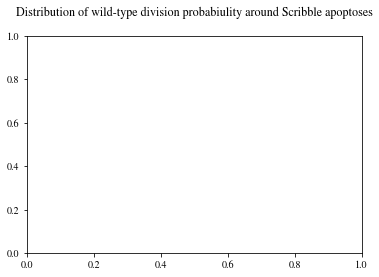

In [3]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title('Distribution of wild-type division probabiulity around Scribble apoptoses\n')



In [4]:
def render(N_events_df, N_cells_df, bins, t_range, R_max):
    """
    Take 2 input dataframes of events and cell apperances and render a ratio plot of the two according to the provided params
    
    N_events_df : pd.DataFrame
        Dataframe showing the cumulative spatiotemporal distribution of cellular events around a series of 
        focal events. For example, the distributions of divisions around focal apoptoses.
        
    N_cells_df : pd.DataFrame
        Corresponding dataframe showing the cumulative spatiotemporal distribution of cells around a series of focal events.
    
    bins : int or tuple
        How to plot the provided data in a 2d histogram. If int then symmetric histogram is plotted.
    
    t_range : int
        Maximum extent of the x axis of the histogram
    
    R_max : int
        Maximum extent of the y axis of the histogram
    
    """
    
    t_min = min(t_range)
    t_max = max(t_range)
    N_events_constrained_df = N_events_df.loc[(N_events_df['Time since apoptosis'] >= t_min) & (N_events_df['Time since apoptosis'] <= t_max) & (N_events_df['Distance from apoptosis'] <= R_max)]
    N_cells_constrained_df = N_cells_df.loc[(N_cells_df['Time since apoptosis'] >= t_min) & (N_cells_df['Time since apoptosis'] <= t_max) & (N_cells_df['Distance from apoptosis'] <= R_max)]

    N_events, xedges, yedges, _ = plt.hist2d(N_events_constrained_df['Time since apoptosis'], N_events_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
    plt.clf()
    N_cells, xedges, yedges, _ = plt.hist2d(N_cells_constrained_df['Time since apoptosis'], N_cells_constrained_df['Distance from apoptosis'],
                      bins=bins, cmap='Blues')
    plt.clf()
    
    P_events = N_events/N_cells
    
    return P_events, xedges, yedges, N_events, N_cells


In [5]:
def feather_load_radial_df(single_scan_file_list, maximum_R = None, crop_amount = 20, fixed_apop_location = False, streamline = True, strict_filtering = False, weights = False):

    """
    A QUICKER function to load each individual radial analysis scan and concatenate them into a cumulative pandas dataframe.
    Needs csv to be saved out as binary feather files first
    
    single_scan_file_list : list of paths
        A list of .csv/feather files of the individual single-focal-cell radial scans to concatenate together

    maximum_R : int
        Defines the maximum radius of a focal scan in pixels, if this radius leaves the field of view
        then that focal apoptosis is either a) excluded from the cumulative scan (if strict_filtering == True)
        or b) The time points at which is leaves the FOV are excluded (if R is given but strict_filtering == False).
        Currently only really makes a difference for post apoptotic times as cell moves around
        before apoptosis so could leave the FOV prior to the xy used as a centoid here

    crop_amount : int
        Defines the cropping amount necessary to exclude boundary effect cells/divisions from
        the radial scan

    streamlined : bool
        If True this returns just the distance from apoptosis and time since apoptosis variables
        in the data frame. If False then it returns data frame as in the .csv file.

    fixed_apop_location : bool
        If True this changes the distance variable from one that follows the apoptotic cell pre-apop
        to one that is the distance between the event and the fixed apoptotic location

    strict_filtering : bool
        This, if True, excludes any focal cells that leave the FOV at any time point by removing those frames from each df

    weights : bool
        This, if True, skips over the previous strict_filtering and leaves all frames in to be weighted


    """

    radial_scan_df = []
    N_focal_cells = 0

    ### if R is not provided then do not filter any focal apoptoses
    if not maximum_R:
        maximum_R = 0
    ### use R to exclude any focal apoptoses that are out of the FOV at the time of apoptosis
    x_range = range(maximum_R+crop_amount, 1200 - (maximum_R+crop_amount))
    y_range = range(maximum_R+crop_amount, 1600 - (maximum_R+crop_amount))
    ### sometimes only provide one df to this function so list will just be str
    if type(single_scan_file_list) == str:
    ### if this is the case make a list of that one fn item
        single_scan_file_list = [single_scan_file_list]

    for file in tqdm(single_scan_file_list):
        file = file.replace('scr_apop_wt_div_xyt/1600.1600/', 'scr_apop_wt_div_xyt/feather/')
        ### get apop id to load apop xyt file
        apop_ID = file.split('/')[-1].split('_N_')[0]
        if maximum_R > 0:
            ### reformat apop ID to fit in previous convention
            if 'Scr' in apop_ID:
                apop_ID = apop_ID.replace('Scr_-','')+'_RFP'
            if 'wt' in apop_ID:
                print('Need to configure this')
            ### load full apo xyt
            apo_xyt_fn = os.path.join('/home/nathan/data/kraken/scr/h2b/giulia/experiment_information/apoptoses/apoptotic_tracks',
                                     f'{apop_ID}.csv')
            apo_df = pd.read_csv(apo_xyt_fn).astype(int)
            del apo_df['Unnamed: 0']
            ### see if any of the frames of the focal cell leave the FOV
            frames_outside_fov = []
            for apo_x, apo_y, apo_t in zip(apo_df['x'], apo_df['y'], apo_df['t']):
                if int(apo_x) not in x_range or int(apo_y) not in  y_range:
                    frames_outside_fov.append(apo_t)
            #print('Frames outside the FOV for ', apop_ID, frames_outside_fov)
            ### if filtering is strict then exclude any focal cell that leves fov
            if strict_filtering == True:
                if len(frames_outside_fov) > 0:
                    continue
        ### if filtering is present but not strict then just exclude time points outside fov
        apo_t, apo_x, apo_y = [int(re.search('txy_(\d+)_(\d+)_(\d+)', file)[i]) for i in range(1,4)]
        ### load dataframe
        df = pd.read_feather(file)
    
        ### eliminate boundary counts spatially
        df = df.loc[(df['x'] >= crop_amount) & (df['x'] <= 1200-crop_amount) & (df['y'] >= crop_amount) & (df['y'] <= 1600-crop_amount)]
        ### eliminate boundary effects temporally (ie. if scan exits fov at any time point) by deleting those frames from the scan
        if maximum_R > 0 and weights == False:
            df = df[~df['Frame'].isin(frames_outside_fov)]
        
        ## convert to SI
        df['Time since apoptosis'] = df['Time since apoptosis']*(4/60)
        df['Distance from apoptosis'] = df['Distance from apoptosis']/3
        
        ### remove unnecessary data
        if streamline:
            del df['x'], df['y'], df['Cell ID'], df['Frame']
            df = df.round(decimals = 2)
            df = df.astype({'Distance from apoptosis':'int'})
        
        ### other way of cutting down on size of df
        df = df.loc[(df['Distance from apoptosis'] <= maximum_R) & (df['Time since apoptosis'] <= 5) & (df['Time since apoptosis'] >= -5)]
        
        ### append to larger df
        radial_scan_df.append(df)
        N_focal_cells +=1
    radial_scan_df = pd.concat(radial_scan_df, axis = 0, ignore_index = True)
    print('Number of focal cells included in cumulative scan:', N_focal_cells)

    if fixed_apop_location == True:
        for i, row in tqdm(radial_scan_df.iterrows(), total = len(radial_scan_df), desc = 'Switching distance (dij) from following apop. cell to fixed apop. location'):
            ### only do preapoptotic times as scan if fixed location post apop
            if row['Time since apoptosis'] < 0:
                focal_ID = row['Focal ID']
                focal_x, focal_y, focal_t = focal_xyt_finder(focal_ID, file_list)
                radial_scan_df.at[i, 'Distance from apoptosis'] = basic_euc_dist(row['x'], row['y'], focal_x, focal_y) / 3 ### scaled from pixels to micrometers

    if weights:
        print(frames_outside_fov)

    return radial_scan_df

# Compile individual scans into cumulative dataframes 

In [6]:
scan_dir = f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600'

In [7]:
files = natsorted(glob.glob(f'{scan_dir}/*.csv'))
event_files = [file for file in files if 'N_events' in file]

In [8]:
event_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-6_N_events_wt_rad_1600_t_range_1600_focal_txy_469_692_922.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-70_N_events_wt_rad_1600_t_range_1600_focal_txy_820_1086_1043.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-73_N_events_wt_rad_1600_t_range_1600_focal_txy_773_1123_1247.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-283_N_events_wt_rad_1600_t_range_1600_focal_txy_913_1085_289.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-298_N_events_wt_rad_1600_t_range_1600_focal_txy_568_404_1103.csv',
 '/home/nathan/data/results/radial_analysis

In [13]:
N_events_df = feather_load_radial_df(event_files,
                                    crop_amount=20, ## no filtering 
                                    maximum_R= 300,
#                              crop_amount = 10, ### how much to crop the spatial measurements to avoid boundary effects
                             streamline = False, 
                            strict_filtering=True)
                           # )

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 403


In [10]:
N_events_df

,Distance from apoptosis,Time since apoptosis,Focal ID
0,37,-5.00,GV0794_Pos4_Scr_-6
1,65,-3.33,GV0794_Pos4_Scr_-6
2,45,3.80,GV0794_Pos7_Scr_-52
3,81,-1.40,GV0794_Pos7_Scr_-328
4,95,-0.20,GV0794_Pos7_Scr_-328
...,...,...,...
7773,50,1.40,GV0820_Pos5_Scr_-420
7774,89,4.93,GV0820_Pos5_Scr_-420
7775,72,1.47,GV0820_Pos5_Scr_-445
7776,85,-2.00,GV0820_Pos5_Scr_-445


In [12]:
N_events_df

,Cell ID,Distance from apoptosis,Frame,x,y,Time since apoptosis,Focal ID
0,23,124.666667,322,569,1311,-9.800000,GV0794_Pos4_Scr_-6
1,22,122.666667,576,420,673,7.133333,GV0794_Pos4_Scr_-6
2,21,79.666667,371,486,784,-6.533333,GV0794_Pos4_Scr_-6
3,20,315.000000,324,391,46,-9.666667,GV0794_Pos4_Scr_-6
4,19,134.333333,376,416,622,-6.200000,GV0794_Pos4_Scr_-6
...,...,...,...,...,...,...,...
340779,1262,459.000000,1036,949,1504,1.600000,GV0820_Pos5_Scr_-972
340780,1276,257.000000,967,20,1157,-3.000000,GV0820_Pos5_Scr_-972
340781,1313,363.000000,1033,1107,878,1.400000,GV0820_Pos5_Scr_-972
340782,1393,398.666667,990,340,1563,-1.466667,GV0820_Pos5_Scr_-972


In [15]:
bins = 40

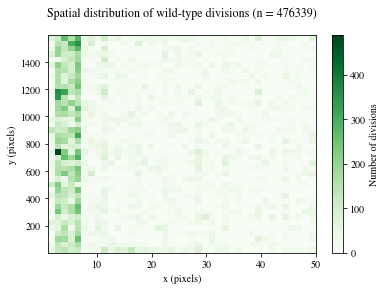

In [34]:

N_events_constrained_df = N_events_df.loc[(N_events_df['x'] <= 50)]# & (N_events_df['Time since apoptosis'] <= t_max) & (N_events_df['Distance from apoptosis'] <= R_max)]
N_events, xedges, yedges, _ = plt.hist2d(N_events_constrained_df['x'], N_events_constrained_df['y'],
                  bins=bins,)

pc = plt.pcolormesh(xedges, yedges, N_events.T, cmap = 'Greens', 
#                     norm=colors.LogNorm(vmin=P_events.min(), vmax=P_events.max()),
#                    
                    shading='auto'
                   )
plt.colorbar(label = 'Number of divisions')
plt.title('Spatial distribution of wild-type divisions (n = 476339)\n')
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
plt.savefig('cropx wt div dist.jpg', bbox_inches = 'tight', dpi = 314)

### Loading cell counts for probability plot

Has to be streamlined for full list

In [15]:
cell_count_files = [file for file in files if 'N_cell' in file]

In [16]:
cell_count_files

['/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-6_N_cells_wt_rad_1600_t_range_1600_focal_txy_469_692_922.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-70_N_cells_wt_rad_1600_t_range_1600_focal_txy_820_1086_1043.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos4_Scr_-73_N_cells_wt_rad_1600_t_range_1600_focal_txy_773_1123_1247.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-283_N_cells_wt_rad_1600_t_range_1600_focal_txy_913_1085_289.csv',
 '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/scr_apop_wt_div_xyt/1600.1600/GV0794_Pos5_Scr_-298_N_cells_wt_rad_1600_t_range_1600_focal_txy_568_404_1103.csv',
 '/home/nathan/data/results/radial_analysis_outp

In [17]:
N_cells_df = feather_load_radial_df(cell_count_files,
                                    crop_amount=10, ## no filtering 
                                    maximum_R= 100,
#                              crop_amount = 10, ### how much to crop the spatial measurements to avoid boundary effects
#                              streamline = False, 
#                             strict_filtering=True)
                            )

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 1839


In [17]:
N_cells_df = feather_load_radial_df(cell_count_files, maximum_R=30, strict_filtering=True
                                   , crop_amount=10
                                   , streamline=True)

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 1476


In [18]:
del N_cells_df['Focal ID']

In [19]:
N_cells_df

,Distance from apoptosis,Time since apoptosis
0,37,-5.0
1,49,-5.0
2,62,-5.0
3,61,-5.0
4,30,-5.0
...,...,...
7537827,32,1.8
7537828,52,1.8
7537829,90,1.8
7537830,87,1.8


In [19]:
N_cells_df

,Distance from apoptosis,Time since apoptosis
0,359,-31.27
1,358,-31.27
2,157,-31.27
3,103,-31.27
4,110,-31.27
...,...,...
245231614,260,1.80
245231615,125,1.80
245231616,169,1.80
245231617,111,1.80


# Plotting the spatiotemporal distribution ratio of events to appearances 

`P_events = N_events/N_cells`

In [25]:
bins = 10

In [26]:
# bins = (50)
# t_range = (-53.33,53.33)
# # R_max = 533.33


# t_min = min(t_range)
# t_max = max(t_range)

# N_events_constrained_df = N_events_df.loc[(N_events_df['Time since apoptosis'] >= t_min) & (N_events_df['Time since apoptosis'] <= t_max) & (N_events_df['Distance from apoptosis'] <= R_max)]
# N_cells_constrained_df = N_cells_df.loc[(N_cells_df['Time since apoptosis'] >= t_min) & (N_cells_df['Time since apoptosis'] <= t_max) & (N_cells_df['Distance from apoptosis'] <= R_max)]
N_events_constrained_df = N_events_df
N_cells_constrained_df = N_cells_df



N_events, xedges, yedges, _ = plt.hist2d(N_events_constrained_df['Time since apoptosis'], N_events_constrained_df['Distance from apoptosis'],
                  bins=bins,)
plt.clf()
N_cells, xedges, yedges, _ = plt.hist2d(N_cells_constrained_df['Time since apoptosis'], N_cells_constrained_df['Distance from apoptosis'],
                  bins=bins,)
plt.clf()

P_events = N_events/N_cells


<Figure size 432x288 with 0 Axes>

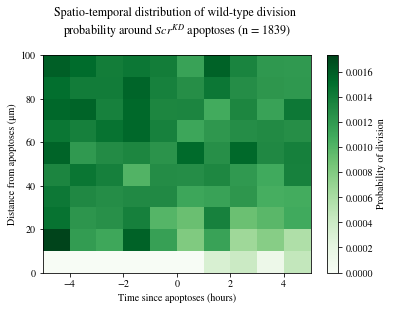

In [27]:
pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Greens', 
#                     norm=colors.LogNorm(vmin=P_events.min(), vmax=P_events.max()),
#                    
                    shading='auto'
                   )
plt.colorbar(label = 'Probability of division')
plt.title('Spatio-temporal distribution of wild-type division \nprobability around $Scr^{KD}$ apoptoses (n = 1839)\n')
plt.xlabel('Time since apoptoses (hours)')
plt.ylabel('Distance from apoptoses (μm)')
plt.savefig('test.jpg', bbox_inches = 'tight', dpi = 314)

In [28]:
N_events[0,:]

array([  0.,  19.,  40.,  56.,  68.,  93., 101., 122., 128., 166.])

In [29]:
N_events[:,1]

array([19., 14., 15., 24., 19., 22., 35., 20., 23., 18.])

In [31]:
P_events[:,1]

array([0.00173595, 0.00118303, 0.00110873, 0.00157926, 0.00115516,
       0.00080885, 0.00114349, 0.00065826, 0.00077658, 0.0005719 ])

In [ ]:
stop

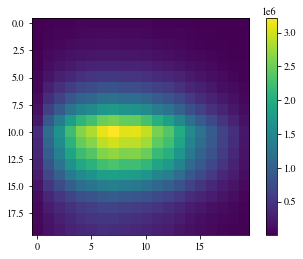

In [55]:
plt.imshow(N_cells)
plt.colorbar()

In [56]:
import numpy as np

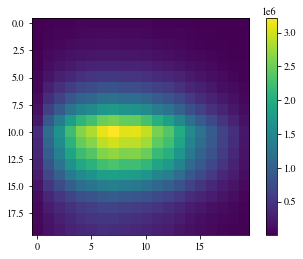

In [57]:
plt.imshow((N_cells))
plt.colorbar()

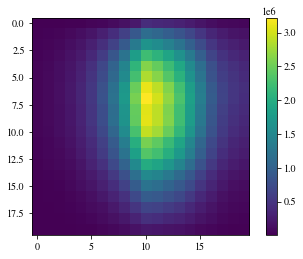

In [58]:
plt.imshow((N_cells.T))
plt.colorbar()

#  area of concern is that the below pcolormesh function is not plotting the heatmap the correct way

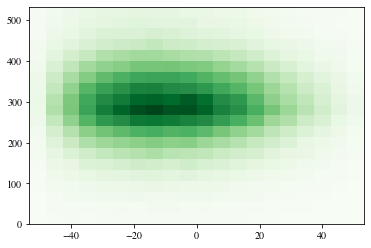

In [61]:
pc = plt.pcolormesh(xedges, yedges, N_events, cmap = 'Greens', 
#                     norm=colors.LogNorm(vmin=P_events.min(), vmax=P_events.max()),
#                    #cmap='PuBu_r',
#                     shading='auto')
                   )

In [ ]:
plt.hist2d(N_events_constrained_df['Time since apoptosis'], N_events_constrained_df['Distance from apoptosis'],
                  bins=bins, cmap='Blues')

In [ ]:
from skimage.io import imshow

In [ ]:
imshow(N_events.T/N_cells.T)

In [ ]:
N_events

In [ ]:
import seaborn as sns

In [ ]:
sns.histplot(data=N_events_constrained_df, x = 'Time since apoptosis', y = 'Distance from apoptosis', bins = (2,8), 
             #stat = 'probability', 
             cbar=True)

In [ ]:
t_range = (-10,10)
R_max = 100
bins = (4,4)
P_events, xedges, yedges, N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events, cmap = 'Greens', 
#                     norm=colors.LogNorm(vmin=P_events.min(), vmax=P_events.max()),
#                    #cmap='PuBu_r',
#                     shading='auto')
                   )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround Scribble apoptoses (N = 270)\nfiltered for R = 100 and T > 10 hours')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('', bbox_inches = 'tight')

In [ ]:
P_events, xedges, yedges,

In [ ]:
plt.imshow(P_events)
plt.colorbar()

# Control measures

### 1. Wild-type divisions around random wild-type points

I have some skepticism about this method as it seems too randomised, leading it to pick up some potential boundary effects of scanning in space and time, i.e. it's suspicious that the peaks in probability are repeated in near pre-apoptotic time.

### 2. Wild-type divisions around wild-type apoptoses

Processed

### 3. Wild-type divisions around Scr. apoptoses in uninduced experiments

Need to find Scr. apoptoses in uninduced experiments.

# Loading control measure #1

In [ ]:
scan_dir = f'/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_control_wt_div_xyt/1600.1600'

In [ ]:
files = natsorted(glob.glob(f'{scan_dir}/*.csv'))
event_files = [file for file in files if 'N_events' in file]
cell_count_files = [file for file in files if 'N_cells' in file]

In [ ]:
len(event_files)

#### temp note: need to change path in function if using typical control

In [ ]:
control_N_events_df = load_radial_df(event_files[0:1900],
                                    limit = 300,
                                    crop_amount = 20, 
                                    streamline = True, 
                                   strict_filtering= True) ### N_cells is large so streamlining advised

In [ ]:
control_N_cells_df = load_radial_df(cell_count_files[0:1900],# ) #no filtering
                                    limit = 300,
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised

#### Plotting control #1

In [ ]:
t_range = (-5,5)
R_max = 100
bins = (10, 5)
P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events_c.T, cmap = 'Greens', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround random wild-type timepoints (N = 480)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')


#### Plotting probability above background for control #1

In [ ]:
t_range = (-10,10)
R_max = 100
bins = (10,20)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine space grain.pdf', bbox_inches = 'tight')

In [ ]:
t_range = (-10,10)
R_max = 100
bins = (300, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine grained in time.pdf')

In [ ]:
t_range = (-5,5)
R_max = 100
bins = (150, 5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -5-5hrs finely grained in time.pdf')

In [ ]:
t_range = (-5,5)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_event_df, control_N_cell_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -5-5hrs coarsely grained.pdf')

# Control measure #2 

### Wild-type divisions around wild-type apoptoses

In [ ]:
control_2_file_path = '/home/nathan/data/results/radial_analysis_output/follow/raw_lists/1600.1600/wt_apop_wt_div_xyt/1600.1600'

In [ ]:
files = natsorted(glob.glob(f'{control_2_file_path}/*.csv'))
event_files = [file for file in files if 'N_events' in file]
cell_count_files = [file for file in files if 'N_cells' in file]

In [ ]:
len(event_files)

In [ ]:
event_files

In [ ]:
control_2_N_events_df = load_radial_df(event_files,# ) #no filtering
                                    limit = 300,
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised
control_2_N_cells_df = load_radial_df(cell_count_files,# ) #no filtering
                                    limit = 300,
                            crop_amount = 20, 
                            streamline = True, 
                           strict_filtering= True) ### N_cells is large so streamlining advised

#### Plotting control #2

In [ ]:
t_range = (-10,10)
R_max = 100
bins = (10, 5)
P_events_c, xedges, yedges,  N_events, N_cells = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)
pc = plt.pcolormesh(xedges, yedges, P_events_c.T, cmap = 'Greens', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability \naround wild-type apoptoses (N = 51)')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr/wt_apop_wt_div probability cropped 0-100um -10-10hrs.pdf')

#### Plotting probability above background for control #2

In [ ]:
t_range = (-10,10)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 457) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -10-10hrs.pdf', bbox_inches = 'tight')

In [ ]:
t_range = (-5,5)
R_max = 100
bins = (10, 10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 457) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -10-10hrs.pdf', bbox_inches = 'tight')

In [ ]:
t_range = (-5,5)
R_max = 100
bins = (75,5)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -5-5hrs finely grained in time.pdf', bbox_inches = 'tight')

In [ ]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'PiYG', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 270) above background measure of\n wild-type division around wild-type apoptoses (N = 51)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300_T>10hr//Difference in probability scr_apop_wt_div wt_apop_wt_div cropped 0-100um -5-5hrs coarse grained.pdf', bbox_inches = 'tight')

# Sandbox

In [ ]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 475) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

#### 1d plots of immediate local neighbourhood

In [ ]:
t_range = (-10,10)
R_max = 20
bins = (10,1)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 475) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

In [ ]:
plt.plot(P_events)
plt.ylim(0,max(P_events))
#plt.xticks(xedges)

# Coefficient of variation



In [ ]:
t_range = (-20,0)
R_max = 100
bins = (10,5)

P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

In [ ]:
import numpy as np

In [ ]:
cv = np.nan_to_num(np.sqrt((1 - P_events) / (P_events * N_cells)), posinf=1)
# pc = plt.pcolormesh(xedges, yedges, cv.T, cmap = 'Spectral', )
# plt.colorbar(label = 'Coefficient of variation',)
# plt.title('Coefficient of variation for distribution of\n wild-type division probability around \nScr. apoptoses (N = 475)\n ')
# plt.ylabel('Distance from apoptoses (μm)')
# plt.xlabel('Time since apoptoses (hours)')

In [ ]:
cv_c = np.nan_to_num(np.sqrt((1 - P_events_c) / (P_events_c * N_cells_c)), posinf=1)
# pc = plt.pcolormesh(xedges, yedges, cv_c.T, cmap = 'Spectral', )
# plt.colorbar(label = 'Coefficient of variation',)
# plt.title('Coefficient of variation for distribution of\n wild-type division probability around \nwild-type apoptoses (N = 105)\n ')
# plt.ylabel('Distance from apoptoses (μm)')
# plt.xlabel('Time since apoptoses (hours)')

In [ ]:
# P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
# P_events_c, xedges, yedges,  N_events_c, N_cells_c = render(control_2_N_events_df, control_2_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T - P_events_c.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)',)
plt.title('Distribution of wild-type division probability around \nScr. apoptoses (N = 475) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

In [ ]:
stat_rel = stat_relevance_calc(bins, P_events, P_events_c, cv, cv_c)
pc = plt.pcolormesh(xedges, yedges, stat_rel.T, cmap = 'gray', )
plt.colorbar(label = '1 = statistically relevant, \n0 = statistically irrelevant')
plt.title('Statistical relevance of  wild-type division probability around \nScr. apoptoses (N = 457) above background measure of\n wild-type division around wild-type apoptoses (N = 105)\n ')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')

In [ ]:
stat_rel.shape

In [ ]:
def stat_relevance_calc(num_bins, P_events, P_events_c, cv, cv_c):
    """
    Function that takes two probability arrays (canon and control), their associated coefficient of variation and calculates the statistical relevance of each bin
    """
    larger_than_array = np.zeros(bins)
    sig_dif_array = np.zeros(bins)
    for i, row in enumerate(P_events):
        for j, element in enumerate(row):
            P_div = P_events[i, j]
            P_div_control = P_events_c[i, j]
            if P_div > P_div_control:
                larger_than_array[i, j] = 1
                measure1 = P_div * (1 - cv[i, j])
                measure2 = P_div_control * (1 + cv_c[i, j])
                if measure1 > measure2:
                    # print(i,j, 'sig dif')
                    sig_dif_array[i, j] = 1
                else:
                    # print(i,j, 'NOT sig dif')
                    sig_dif_array[i, j] = 0
            elif (
                P_div == P_div_control == 0
            ):  ### if P_div is zero then that is bc there arent enough events counted and it is not statistically relevant
                sig_dif_array[i, j] = 0
            elif P_div < P_div_control:
                larger_than_array[i, j] = 0
                measure1 = P_div_control * (1 - cv_c[i, j])
                measure2 = P_div * (1 + cv[i, j])
                if measure1 > measure2:
                    # print(i,j, 'sig dif')
                    sig_dif_array[i, j] = 1
                else:
                    # print(i,j, 'NOT sig dif')
                    sig_dif_array[i, j] = 0
    #         else:
    #             print('Error calculating statistical relevance at index', i,j)
    return sig_dif_array

# what are the cell counts in the first spatial bins???

In [ ]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, P_events.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)'
    )
#plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine space grain.pdf', bbox_inches = 'tight')

In [ ]:
t_range = (-5,5)
R_max = 100
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, N_events.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)'
    )
#plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine space grain.pdf', bbox_inches = 'tight')

In [ ]:
t_range = (-5,5)
R_max = 20
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, N_events.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)'
    )
#plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine space grain.pdf', bbox_inches = 'tight')

In [ ]:
t_range = (-5,5)
R_max = 20
bins = (10,10)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, N_cells.T, cmap = 'Spectral', )
plt.colorbar(label = 'Probability of wild-type division \n(No. divisions/No. cells)'
    )
#plt.title('Distribution of wild-type division probability \naround filtered Scr. apoptoses (N = 270) \n above background wild-type division rate (N = 248)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/strict_filtering_300/Difference in probability scr_apop_wt_div wt_control_wt_div cropped 0-100um -10-10hrs fine space grain.pdf', bbox_inches = 'tight')

In [ ]:
t_range = (-20,20)
R_max = 20
bins = (100,20)
P_events, xedges, yedges,  N_events, N_cells = render(N_events_df, N_cells_df, bins, t_range, R_max)
#P_events_c, xedges, yedges,  N_events, N_cells = render(control_N_events_df, control_N_cells_df, bins, t_range, R_max)

pc = plt.pcolormesh(xedges, yedges, N_cells.T, cmap = 'Spectral', )
plt.colorbar(label = 'Number of wild-type cells \ncropped to show anything above none'
    )
plt.clim(0,1)
plt.title('Distribution of nearest neighbour wild-type cells\naround filtered Scr. apoptoses (N = 457)\n')
plt.ylabel('Distance from apoptoses (μm)')
plt.xlabel('Time since apoptoses (hours)')
#plt.savefig('/home/nathan/data/results/radial_analysis_output/follow/cumulative_plots/new_method/proofs/Distribution of nearest neighbour wild-type cells around filtered Scr. apoptoses (N = 457) -20-20hrs20um.pdf', bbox_inches = 'tight')

In [ ]:
N_cells_df

In [ ]:
N_events_df = load_radial_df(event_files,#) ## no filtering 
                                    limit = 300,
                             crop_amount = 20, ### how much to crop the spatial measurements to avoid boundary effects
                             streamline = False, 
                            strict_filtering=True)

In [ ]:
N_events_df

In [ ]:
for fn in event_files:
    if 'GV0807_Pos4_Scr_-556' in fn:
        print(fn)

In [ ]:
for i in N_events_df.index:
    
    if N_events_df['Distance from apoptosis'][i] < 12:
        if N_events_df['Time since apoptosis'][i] < 0:
            print(N_events_df.loc[i])

In [ ]:
for i in N_cells_df.index:
    if N_cells_df['Distance from apoptosis'][i] < 5:
        if N_cells_df['Time since apoptosis'][i] < 0:
            print(N_cells_df.loc[i])